In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from colossus.cosmology import cosmology
from scipy.optimize import fsolve
import emcee
import pyccl as ccl
import random
from colossus.lss import bias
from matplotlib.ticker import LogLocator, ScalarFormatter
import seaborn as sns
import pandas as pd
from scipy.stats import chi2 as chi2dist
from numpy.linalg import solve

In [2]:

h=0.6774
omega_b=0.0486
omega_m=0.3089
omega_c=omega_m-omega_b
omega_l=0.6911
ns=0.9667
sigma8=0.8159
my_cosmo = {'flat': True, 'H0': h*100, 'Om0': omega_c, 'Ob0': omega_b, 'sigma8': sigma8, 'ns': ns}
cosmo2 = cosmology.setCosmology('my_cosmo', **my_cosmo)

cosmo = ccl.Cosmology(Omega_c=omega_c, Omega_b=omega_b, h=h, sigma8=sigma8, n_s=ns,transfer_function='boltzmann_camb')

In [3]:
def mcmcfit(x, y, invcov):

    # 定义线性模型
    def model(params, x):
        b = params
        return b

    # 定义对数似然函数
    def log_likelihood(params, x, y, invcov):
        model_y = model(params, x)
        diff=np.mat(y - model_y)
        return -0.5 * np.dot(diff, np.dot(invcov, diff.T))

    # 定义对数先验概率
    def log_prior(params):
        b = params
        if -10. < b < 10.:
            return 0.0
        return -np.inf

    # 定义对数后验概率
    def log_probability(params, x, y, invcov):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params, x, y, invcov)

    # 初始化参数
    nwalkers = 10
    p0 = np.random.rand(nwalkers, 1) * 2 - 1

    # 设置MCMC采样器
    sampler = emcee.EnsembleSampler(nwalkers, 1, log_probability, args=(x, y, invcov))

    # 运行MCMC采样
    sampler.run_mcmc(p0, 5000, progress=True)
    samples = sampler.get_chain()

    # 计算参数的均值和标准差
    nburn = 200
    quantiles = np.array([16., 50., 84.])

    parameter_results = np.percentile(samples[nburn:, :].flatten(), quantiles)
    mean_b = parameter_results[1]
    std_b_minus = parameter_results[1] - parameter_results[0]
    std_b_plus = parameter_results[2] - parameter_results[1]

    return mean_b, std_b_minus, std_b_plus,samples[nburn:, :].flatten()

In [4]:

def xi_mm(rr,a):
    if(len(rr) == 1 and rr[0] < 1e-3):
        return cosmo2.correlationFunction([1e-3], z=1./a-1., derivative=False, ps_args={'model': 'camb'})
    else:
        return cosmo2.correlationFunction(rr, z=1./a-1., derivative=False, ps_args={'model': 'camb'})

def zeta_0(rr,a):
    zeta0=(1+1.17*xi_mm(rr,a))**1.49/(1+0.69*xi_mm(rr,a))**2.09
    return zeta0

def r_phi(a):
    phi=0.9
    def zeta0_ximm(rr):
        ztmm=zeta_0(rr,a)*xi_mm(rr,a)-10**phi
        return ztmm
    rphi=fsolve(zeta0_ximm, 1.)
    return rphi

def zeta(rr,a):
    newr=np.zeros_like(rr)
    rp=r_phi(a)
    for i in range(len(rr)):
        if(rr[i] < rp):
            newr[i]=rp
        else:
            newr[i]=rr[i]
    zt=zeta_0(newr,a)
    return zt
    
def wp(rp, z):
    ppi=np.linspace(0,100,1000) #Mpc/h
    ppi=(ppi[1:]+ppi[:-1])/2.
    dpi=ppi[1]-ppi[0]
    wps=[]
    a=1/(1+z)
    for i in range(len(rp)):
        r=np.sqrt(ppi**2+rp[i]**2)
        zeta0=zeta(r,a)
        wps.append(np.sum(zeta0*zeta0*xi_mm(r,a))*dpi*2)
    return np.array(wps)
    
	
def decodePairs(pairs, njack, rbin, pibin):
    # pair data format
    # (njack_0, rp_0, pi_0), (njack_1, , rp_0, pi_0), ... (njack_n, , rp_0, pi_0)
    # (njack_0, rp_0, pi_1), (njack_1, , rp_0, pi_1), ... (njack_n, , rp_0, pi_1)
    # ...
    # (njack_0, rp_0, pi_n), (njack_1, , rp_0, pi_n), ... (njack_n, , rp_0, pi_n)
    # (njack_0, rp_1, pi_0), (njack_1, , rp_1, pi_0), ... (njack_n, , rp_1, pi_0)
    # ... ...
    # (njack_0, rp_n, pi_n), (njack_1, , rp_n, pi_n), ... (njack_n, , rp_n, pi_n)
    mat_pairs = np.zeros((njack, rbin, pibin))
    for i in range(rbin):
        for j in range(pibin):
            for k in range(njack):
                mat_pairs[k,i,j] = pairs[njack*(i*pibin+j)+k]
    return mat_pairs

def calcJKCov(wp_jk):
    n_r = wp_jk.shape[0]
    n_jk = wp_jk.shape[1]
    wp_mean = np.average(wp_jk, axis = 1)
    cov = np.zeros((n_r, n_r))
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            cov[i,j] = np.sum((wp_jk[i]-wp_mean[i])*(wp_jk[j]-wp_mean[j]))
    cov *= (n_jk-1.)/n_jk
    return wp_mean,cov


def cal_wp_bias_ratio(rbin, pimax, pibin,pimaxint, bias1,bias2,njack, outputdir1,outputdir2):
    deltapi= float(pimax)/float(pibin)
    
    dd_file=outputdir1+"pairs_dd.dat"
    dr_file=outputdir1+"pairs_dr.dat"
    rr_file=outputdir1+"pairs_rr.dat"
    data=np.loadtxt(outputdir1+"num_gal_ran.dat")
    ngal=data[0]
    nran=data[1]
    print(ngal,nran)
    dd = np.fromfile(dd_file, dtype = float)
    dd = decodePairs(dd, njack, rbin, pibin)/(ngal*ngal)
    dr = np.fromfile(dr_file, dtype = float)
    dr = decodePairs(dr, njack, rbin, pibin)/(ngal*nran)
    rr = np.fromfile(rr_file, dtype = float)
    rr = decodePairs(rr, njack, rbin, pibin)/(nran*nran)

    xi = (dd - 2.*dr + rr)/rr
    #xi = dd/rr-1
    wp_jk1 = 2.*np.sum(xi[:,:,:pimaxint], axis = 2)*deltapi
    wp1,cov1 = calcJKCov(np.transpose(wp_jk1))

    dd_file=outputdir2+"pairs_dd.dat"
    dr_file=outputdir2+"pairs_dr.dat"
    rr_file=outputdir2+"pairs_rr.dat"
    data=np.loadtxt(outputdir2+"num_gal_ran.dat")
    ngal=data[0]
    nran=data[1]
    print(ngal,nran)
    dd = np.fromfile(dd_file, dtype = float)
    dd = decodePairs(dd, njack, rbin, pibin)/(ngal*ngal)
    dr = np.fromfile(dr_file, dtype = float)
    dr = decodePairs(dr, njack, rbin, pibin)/(ngal*nran)
    rr = np.fromfile(rr_file, dtype = float)
    rr = decodePairs(rr, njack, rbin, pibin)/(nran*nran)

    xi = (dd - 2.*dr + rr)/rr
    #xi = dd/rr-1
    wp_jk2 = 2.*np.sum(xi[:,:,:pimaxint], axis = 2)*deltapi
    wp2,cov2 = calcJKCov(np.transpose(wp_jk2))

    ratio,cov = calcJKCov(np.transpose(np.sqrt((wp_jk2/bias2**2)/(wp_jk1/bias1**2))))
    return wp1,np.sqrt(np.diag(cov1)),wp2,np.sqrt(np.diag(cov2)),ratio, np.sqrt(np.diag(cov)),cov, wp_jk1/wp_jk2


def cal_wp_bias_ratio_3(rbin, pimax, pibin,pimaxint,njack, outputdir1,outputdir2):
    deltapi= float(pimax)/float(pibin)
    
    dd_file=outputdir1+"pairs_dd.dat"
    dr_file=outputdir1+"pairs_dr.dat"
    rr_file=outputdir1+"pairs_rr.dat"
    data=np.loadtxt(outputdir1+"num_gal_ran.dat")
    ngal=data[0]
    nran=data[1]
    print(ngal,nran)
    dd = np.fromfile(dd_file, dtype = float)
    dd = decodePairs(dd, njack, rbin, pibin)/(ngal*ngal)
    dr = np.fromfile(dr_file, dtype = float)
    dr = decodePairs(dr, njack, rbin, pibin)/(ngal*nran)
    rr = np.fromfile(rr_file, dtype = float)
    rr = decodePairs(rr, njack, rbin, pibin)/(nran*nran)

    xi = (dd - 2.*dr + rr)/rr
    #xi = dd/rr-1
    wp_jk1 = 2.*np.sum(xi[:,:,:pimaxint], axis = 2)*deltapi
    wp1,cov1 = calcJKCov(np.transpose(wp_jk1))

    dd_file=outputdir2+"pairs_dd.dat"
    dr_file=outputdir2+"pairs_dr.dat"
    rr_file=outputdir2+"pairs_rr.dat"
    data=np.loadtxt(outputdir2+"num_gal_ran.dat")
    ngal=data[0]
    nran=data[1]
    print(ngal,nran)
    dd = np.fromfile(dd_file, dtype = float)
    dd = decodePairs(dd, njack, rbin, pibin)/(ngal*ngal)
    dr = np.fromfile(dr_file, dtype = float)
    dr = decodePairs(dr, njack, rbin, pibin)/(ngal*nran)
    rr = np.fromfile(rr_file, dtype = float)
    rr = decodePairs(rr, njack, rbin, pibin)/(nran*nran)

    xi = (dd - 2.*dr + rr)/rr
    #xi = dd/rr-1
    wp_jk2 = 2.*np.sum(xi[:,:,:pimaxint], axis = 2)*deltapi
    wp2,cov2 = calcJKCov(np.transpose(wp_jk2))

    ratio,cov = calcJKCov(np.transpose(np.sqrt(wp_jk2/wp_jk1)))
    return wp1,np.sqrt(np.diag(cov1)),wp2,np.sqrt(np.diag(cov2)),ratio, np.sqrt(np.diag(cov)),cov, np.sqrt(wp_jk2/wp_jk1)


def fit_constant_with_cov(r, C_r):
    """
    广义最小二乘拟合常数模型 r_b0
    r : array_like, shape (n,)
        数据向量
    C_r : array_like, shape (n, n)
        数据的协方差矩阵

    Returns
    -------
    r_b0 : float
        拟合得到的常数
    sigma_r_b0 : float
        拟合常数的不确定性（标准差）
    """
    r = np.asarray(r)
    C_r = np.asarray(C_r)
    
    # 计算逆协方差矩阵
    Cinv = np.linalg.inv(C_r)
    
    ones = np.ones_like(r)
    
    numerator = ones @ Cinv @ r
    denominator = ones @ Cinv @ ones
    
    r_b0 = numerator / denominator
    sigma_r_b0 = np.sqrt(1.0 / denominator)
    
    return r_b0, sigma_r_b0

    

def fit_Chi2(r, C_r):
    """
    广义最小二乘拟合常数模型 r_b0
    r : array_like, shape (n,)
        数据向量
    C_r : array_like, shape (n, n)
        数据的协方差矩阵

    Returns
    -------
    r_b0 : float
        拟合得到的常数
    sigma_r_b0 : float
        拟合常数的不确定性（标准差）
    """
    r = np.asarray(r)
    C_r = np.asarray(C_r)
    
    # 计算逆协方差矩阵
    Cinv = np.linalg.inv(C_r)
    
    ones = r-np.ones_like(r)
    denominator = ones @ Cinv @ ones
    
    return np.sqrt(denominator)

25512.0 255120.0
23176.0 231760.0
25512.0 255120.0
23176.0 231760.0
gls 0.8848040001734324 0.05983300141486309
gls large-scale 0.9028327862495337 0.0668039866775924


100%|██████████| 5000/5000 [00:02<00:00, 2189.23it/s]


0.8835921686929968 0.06020101917678433 0.05989852999465106
S/N:  3.2697799692632157 3.2697799692632152


100%|██████████| 5000/5000 [00:02<00:00, 2168.40it/s]


0.9037840928572101 0.06790318447673727 0.06682135528067634
large-scale S/N:  2.0164488860844147 3.2697799692632152
projection S/N:  3.138033585772331
gls 1.0009638620830592 0.009454711482258132


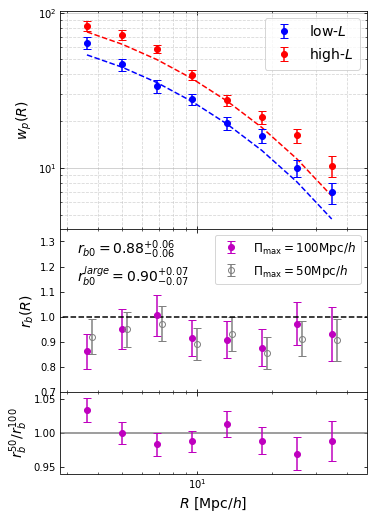

In [11]:


def shrink_cov(C):
    lamb = 0.05
    return (1-lamb)*C + lamb*np.diag(np.diag(C))
    
njk=100
M1=13.42529766
M2=13.80874081
zz=[0.3183509812149577,0.32184142323886783]
Ab_ggl=[0.91,0.82]
delta_Mh=200
data_path1="data/ggl-chains-mag/"
samples=[]
for isig in range(2):
    file_path1 = data_path1 + "chain_10000_steps-intpl-M-c-rs-fc-bh-n"+str(isig+1)+".npz"
    data1 = np.load(file_path1)
    samples1 = np.array(data1['arr_0'])
    nburn=int(samples1.shape[0]*0.1)
    random.shuffle(samples1[nburn:,0])
    bias_t10=bias.haloBias(10**samples1[nburn:,0], zz[isig], mdef='200m', model='tinker10')
    #bias_t10=ccl.massfunction.halo_bias(cosmo, 10**samples1[nburn:,0]/h, a=1/(1+zz1), overdensity=delta_Mh)
    samples.append(bias_t10)
chains_ratio_t10=samples[0]/samples[1]
rb_ggl=np.mean(chains_ratio_t10)
rb_ggl_var=np.var(chains_ratio_t10)

dtype = [('R', float), ('Rmin', float), ('Rmax', float), ('wp', float), ('wp_err', float)]
fig, axs = plt.subplots(
    3, 1,
    figsize=(5.5, 8.5),
    sharex=True,
    gridspec_kw={'height_ratios': [4, 3, 1.5]}   # 3:2:1 的高度比
)

data_dir="data/"
dir1=data_dir+"results-specz-mag-sub1-2/"
dir2=data_dir+"results-specz-mag-sub2-2/"
wp1_100,wp_err1_100,wp2_100,wp_err2_100,ratio_100, ratio_err_100, ratio_cov_100, ratio_jk_100 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=100,pibin = 200,njack = njk, outputdir1=dir1,outputdir2=dir2)
wp1_200,wp_err1_200,wp2_200,wp_err2_200,ratio_200, ratio_err_200, ratio_cov_200, ratio_jk_200 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=50,pibin = 200, njack = njk, outputdir1=dir1,outputdir2=dir2)


ratio_cov_100=(ratio_cov_100*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_100, ratio_100))#*np.eye(9)
ratio_cov_200=(ratio_cov_200*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_200, ratio_200))#*np.eye(9)
ratio_cov_100=shrink_cov(ratio_cov_100)
ratio_err_100=np.sqrt(np.diag(ratio_cov_100))
ratio_err_200=np.sqrt(np.diag(ratio_cov_200))
ratio_100=ratio_100*rb_ggl
ratio_200=ratio_200*rb_ggl

#ratio_100,ratio_cov_100=build_Cr_from_chain_and_jk(chains_ratio_t10, ratio_jk_100, jitter=1e-12, use_log=False)
#ratio_cov_100=shrink_cov(ratio_cov_100)
#ratio_err_100=np.sqrt(np.diag(ratio_cov_100))

rb0,rb0_err=fit_constant_with_cov(ratio_100, ratio_cov_100)
print('gls',rb0,rb0_err)
ind_large=4
rb0,rb0_err=fit_constant_with_cov(ratio_100[4:], ratio_cov_100[4:,4:])
print('gls large-scale',rb0,rb0_err)

file_path = dir1 + "wp_results.dat"
data = np.genfromtxt(file_path, delimiter=' ', comments='#', dtype=dtype)
rcen=data['R']

bias1=bias.haloBias(10**M1, zz[0], mdef='200m', model='tinker10')*Ab_ggl[0]
bias2=bias.haloBias(10**M2, zz[1], mdef='200m', model='tinker10')*Ab_ggl[1]
axs[0].plot(rcen,bias1**2*wp(rcen, zz[0]),'b--')
axs[0].plot(rcen,bias2**2*wp(rcen, zz[1]),'r--')
axs[0].errorbar(rcen,wp1_100,yerr=wp_err1_100,label=r"low-$L$",fmt='o',capsize=4,c='b')
axs[0].errorbar(rcen,wp2_100,yerr=wp_err2_100,label=r"high-$L$",fmt='o',capsize=4,c='r')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
    
axs[1].errorbar(rcen,ratio_100,yerr=ratio_err_100,fmt='o',capsize=4,c='m',label=r'$\Pi_{\rm max}=100{\rm Mpc}/h$')
axs[1].errorbar(rcen*1.05,ratio_200,yerr=ratio_err_200,fmt='o',capsize=4,c='gray',markerfacecolor='none',label=r'$\Pi_{\rm max}=50{\rm Mpc}/h$')
axs[1].legend(fontsize=12)

inv_ratio_cov=np.linalg.inv(ratio_cov_100)
b,bem,bep,chains22 = mcmcfit(rcen,ratio_100,inv_ratio_cov)
print(b,bem,bep)
text_str = r"$r_{{b0}} = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(b, bep, bem)
diff=np.mat(ratio_100-1)
snr=np.sqrt(np.dot(diff, np.dot(inv_ratio_cov, diff.T)))[0,0]
print("S/N: ",snr,fit_Chi2(ratio_100,ratio_cov_100))

inv_ratio_cov=np.linalg.inv(ratio_cov_100[4:,4:])
b,bem,bep,chains22 = mcmcfit(rcen[4:],ratio_100[4:],inv_ratio_cov)
print(b,bem,bep)
text_str2 = r"$r_{{b0}}^{{large}} = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(b, bep, bem)
diff=np.mat(ratio_100[4:]-1)
snr=np.sqrt(np.dot(diff, np.dot(inv_ratio_cov, diff.T)))[0,0]
print("large-scale S/N: ",snr,fit_Chi2(ratio_100,ratio_cov_100))

axs[1].plot([0.1,100],np.ones(2),'--',c='k')
#axs[1].plot([0.1,100],np.ones(2)*b,'-',c='darkorange')
#axs[1].fill_between([0.1,100],np.ones(2)*(b-bem),np.ones(2)*(b+bem),alpha=0.4,color='darkorange')

axs[1].set_xscale('log')
axs[1].text(3.3,1.25,text_str,fontsize=14)
axs[1].text(3.3,1.14,text_str2,fontsize=14)
#axs[1].text(2.3,1.25,'S/N = '+str(format(snr, '.1f')),fontsize=14)

axs[2].set_xlabel(r'$R$ [Mpc/$h$]',fontsize=14)
axs[1].set_ylim(0.7,1.35)

axs[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axs[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axs[2].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axs[1].set_xlim(2.8,48)
axs[0].legend(fontsize=14)
axs[0].set_ylabel('$w_p (R)$',fontsize=14)
axs[1].set_ylabel('$r_b (R)$',fontsize=14)
    
ratio_ratio,cov = calcJKCov(np.transpose(np.sqrt(ratio_jk_200/ratio_jk_100)))
ratio_ratio_err = np.sqrt(np.diag(cov))


inv_ratio_cov=np.linalg.inv(cov)
diff=np.mat(ratio_ratio-1)
snr=np.sqrt(np.dot(diff, np.dot(inv_ratio_cov, diff.T)))[0,0]
print("projection S/N: ",snr)

rb0,rb0_err=fit_constant_with_cov(ratio_ratio, cov)
print('gls',rb0,rb0_err)

axs[2].plot([0.1,100],np.ones(2),'-',c='gray')
axs[2].errorbar(rcen,ratio_ratio,yerr=ratio_ratio_err,fmt='o',capsize=4,c='m')
axs[2].set_ylim(0.94,1.06)
axs[2].set_ylabel(r'$r_b^{\rm 50}/r_b^{\rm 100}$',fontsize=14)
axs[0].grid(True, which='major', linestyle='-', alpha=0.7)
axs[0].grid(True, which='minor', linestyle='--', alpha=0.5)

plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('wp-diff_mag-specz.png',bbox_inches = 'tight',dpi=200)


In [12]:

np.savez(
    'data/wp_results-obs-2.npz',
    rp_centers=rcen,
    wp_small=wp1_100,
    wp_err_small=wp_err1_100,
    wp_large=wp2_100,
    wp_err_large=wp_err2_100,
    ratio_mean=ratio_100,
    ratio_err=ratio_err_100,
    C_total_ratio=ratio_cov_100
)

18112.0 181120.0
16728.0 167280.0
18112.0 181120.0
16728.0 167280.0
gls 0.8379831673617282 0.05934007396901684
7400.0 74000.0
6448.0 64480.0
7400.0 74000.0
6448.0 64480.0
gls 0.9256797672734043 0.07084270511753404


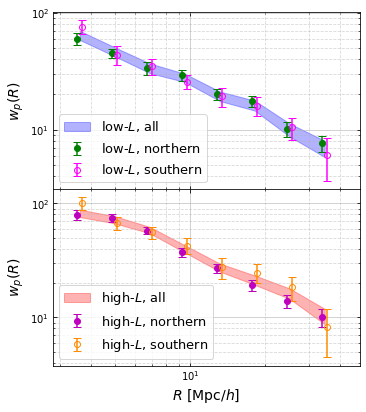

In [14]:

data = np.load('data/wp_results-obs-2.npz')
rcen = data['rp_centers']
wp1_100 = data['wp_small']
wp_err1_100 = data['wp_err_small']
wp2_100 = data['wp_large']
wp_err2_100 = data['wp_err_large']
ratio_100 = data['ratio_mean']
ratio_err_100 = data['ratio_err']
covr_obs = data['C_total_ratio']


fig, axs = plt.subplots(
    2, 1,
    figsize=(5.5, 6.5),
    sharex=True,
    gridspec_kw={'height_ratios': [1,1]}   # 3:2:1 的高度比
)

axs[0].fill_between(rcen,wp1_100-wp_err1_100,wp1_100+wp_err1_100,alpha=0.3,color='b', label='low-$L$, all')
axs[1].fill_between(rcen,wp2_100-wp_err2_100,wp2_100+wp_err2_100,alpha=0.3,color='r', label='high-$L$, all')


data_dir="data/"
dir1=data_dir+"results-specz-mag-sub1-2-regA/"
dir2=data_dir+"results-specz-mag-sub2-2-regA/"
file_path = dir1 + "wp_results.npz"
data = np.load(file_path)
rcen=data['R']
njk=data['njack']
wp1_100,wp_err1_100,wp2_100,wp_err2_100,ratio_100, ratio_err_100, ratio_cov_100, ratio_jk_100 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=100,pibin = 200,njack = njk, outputdir1=dir1,outputdir2=dir2)
wp1_200,wp_err1_200,wp2_200,wp_err2_200,ratio_200, ratio_err_200, ratio_cov_200, ratio_jk_200 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=50,pibin = 200, njack = njk, outputdir1=dir1,outputdir2=dir2)


ratio_cov_100=(ratio_cov_100*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_100, ratio_100))#*np.eye(9)
ratio_cov_200=(ratio_cov_200*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_200, ratio_200))#*np.eye(9)
ratio_cov_100=shrink_cov(ratio_cov_100)
ratio_err_100=np.sqrt(np.diag(ratio_cov_100))
ratio_err_200=np.sqrt(np.diag(ratio_cov_200))
ratio_100=ratio_100*rb_ggl
ratio_200=ratio_200*rb_ggl

rb0,rb0_err=fit_constant_with_cov(ratio_100, ratio_cov_100)
print('gls',rb0,rb0_err)

file_path = dir1 + "wp_results.dat"
data = np.genfromtxt(file_path, delimiter=' ', comments='#', dtype=dtype)
rcen=data['R']

axs[0].errorbar(rcen*10**-0.01,wp1_100,yerr=wp_err1_100,label=r"low-$L$, northern",fmt='o',capsize=4,c='g')
axs[1].errorbar(rcen*10**-0.01,wp2_100,yerr=wp_err2_100,label=r"high-$L$, northern",fmt='o',capsize=4,c='m')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axs[0].set_xlim(2.8,48)
axs[0].set_ylabel('$w_p (R)$',fontsize=14)

data_dir="data/"
dir1=data_dir+"results-specz-mag-sub1-2-regB/"
dir2=data_dir+"results-specz-mag-sub2-2-regB/"
file_path = dir1 + "wp_results.npz"
data = np.load(file_path)
rcen=data['R']
njk=data['njack']
wp1_100,wp_err1_100,wp2_100,wp_err2_100,ratio_100, ratio_err_100, ratio_cov_100, ratio_jk_100 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=100,pibin = 200,njack = njk, outputdir1=dir1,outputdir2=dir2)
wp1_200,wp_err1_200,wp2_200,wp_err2_200,ratio_200, ratio_err_200, ratio_cov_200, ratio_jk_200 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=50,pibin = 200, njack = njk, outputdir1=dir1,outputdir2=dir2)


ratio_cov_100=(ratio_cov_100*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_100, ratio_100))#*np.eye(9)
ratio_cov_200=(ratio_cov_200*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_200, ratio_200))#*np.eye(9)
ratio_cov_100=shrink_cov(ratio_cov_100)
ratio_err_100=np.sqrt(np.diag(ratio_cov_100))
ratio_err_200=np.sqrt(np.diag(ratio_cov_200))
ratio_100=ratio_100*rb_ggl
ratio_200=ratio_200*rb_ggl

rb0,rb0_err=fit_constant_with_cov(ratio_100, ratio_cov_100)
print('gls',rb0,rb0_err)
axs[0].errorbar(rcen*10**0.01,wp1_100,yerr=wp_err1_100,label=r"low-$L$, southern",fmt='o',capsize=4,c='fuchsia',markerfacecolor='none')
axs[1].errorbar(rcen*10**0.01,wp2_100,yerr=wp_err2_100,label=r"high-$L$, southern",fmt='o',capsize=4,c='darkorange',markerfacecolor='none')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axs[1].set_xlim(2.8,48)
axs[1].legend(fontsize=13)
axs[0].legend(fontsize=13)
axs[1].set_ylabel('$w_p (R)$',fontsize=14)
axs[1].set_xlabel(r'$R$ [Mpc/$h$]',fontsize=14)
axs[1].grid(True, which='major', linestyle='-', alpha=0.7)
axs[1].grid(True, which='minor', linestyle='--', alpha=0.5)
axs[0].grid(True, which='major', linestyle='-', alpha=0.7)
axs[0].grid(True, which='minor', linestyle='--', alpha=0.5)


plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('wp-diff_mag-subregion.png',bbox_inches = 'tight',dpi=200)

In [15]:
rb0_l=[]
rb0_err_l=[]

models=['tinker10','cole89','jing98','sheth01','seljak04','pillepich10','bhattacharya11','comparat17']

for im in range(len(models)):
    njk=100
    M1=13.42529766
    M2=13.80874081
    zz=[0.3183509812149577,0.32184142323886783]
    delta_Mh=200
    data_path1="data/ggl-chains-mag/"
    samples=[]
    for isig in range(2):
        file_path1 = data_path1 + "chain_10000_steps-intpl-M-c-rs-fc-bh-n"+str(isig+1)+".npz"
        data1 = np.load(file_path1)
        samples1 = np.array(data1['arr_0'])
        nburn=int(samples1.shape[0]*0.1)
        random.shuffle(samples1[nburn:,0])
        bias_t10=bias.haloBias(10**samples1[nburn:,0], zz[isig], mdef='200m', model=models[im])
        #bias_t10=ccl.massfunction.halo_bias(cosmo, 10**samples1[nburn:,0]/h, a=1/(1+zz1), overdensity=delta_Mh)
        samples.append(bias_t10)
    chains_ratio_t10=samples[0]/samples[1]
    rb_ggl=np.mean(chains_ratio_t10)
    rb_ggl_var=np.var(chains_ratio_t10)
    
    data_dir="data/"
    dir1=data_dir+"results-specz-mag-sub1-2/"
    dir2=data_dir+"results-specz-mag-sub2-2/"
    wp1_100,wp_err1_100,wp2_100,wp_err2_100,ratio_100, ratio_err_100, ratio_cov_100, ratio_jk_100 = cal_wp_bias_ratio_3(rbin = 8, pimax = 200, pimaxint=100,pibin = 200,njack = njk, outputdir1=dir1,outputdir2=dir2)
    
    ratio_cov_100=(ratio_cov_100*(rb_ggl_var+rb_ggl**2)+rb_ggl_var*np.outer(ratio_100, ratio_100))#*np.eye(9)
    ratio_cov_100=shrink_cov(ratio_cov_100)
    ratio_err_100=np.sqrt(np.diag(ratio_cov_100))
    ratio_100=ratio_100*rb_ggl
    
    rb0,rb0_err=fit_constant_with_cov(ratio_100, ratio_cov_100)
    print('gls',rb0,rb0_err)
    rb0_l.append(rb0)
    rb0_err_l.append(rb0_err)

25512.0 255120.0
23176.0 231760.0
gls 0.8847783737817267 0.05986754133771224
25512.0 255120.0
23176.0 231760.0
gls 0.8775296428856025 0.0611953938414861
25512.0 255120.0
23176.0 231760.0
gls 0.8807159358516348 0.06070795846832996
25512.0 255120.0
23176.0 231760.0
gls 0.9188663585940304 0.05593741124215308
25512.0 255120.0
23176.0 231760.0
gls 0.7922408839888168 0.070285771780157
25512.0 255120.0
23176.0 231760.0
gls 0.8809224452139957 0.0604246415965356
25512.0 255120.0
23176.0 231760.0
gls 0.8958221404620753 0.05830459924811375
25512.0 255120.0
23176.0 231760.0
gls 0.8861895799872437 0.05979292643730236


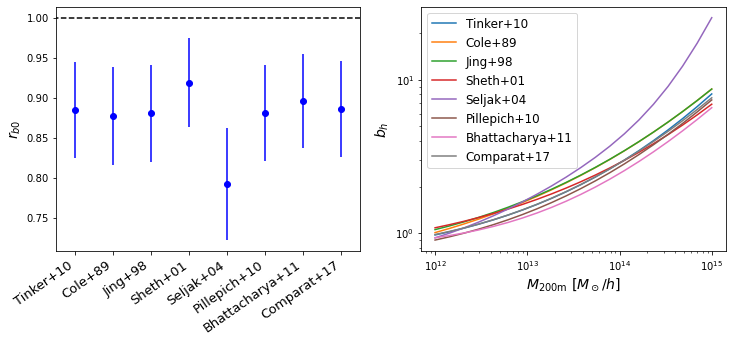

In [16]:
labels=['Tinker+10','Cole+89','Jing+98','Sheth+01','Seljak+04','Pillepich+10','Bhattacharya+11','Comparat+17']

plt.figure(figsize=(12,4.5))
plt.subplot(121)

plt.plot([0,9], np.ones(2), '--', c='k')
plt.errorbar(np.arange(1, len(models)+1), rb0_l, yerr=rb0_err_l, fmt='o', c='b')
#plt.xlabel("Bias Models", fontsize=14)
plt.ylabel("$r_{b0}$", fontsize=14)
plt.xlim(0.5, 8.5)

# 设置倾斜的x轴标签
plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=35, ha='right',fontsize=13)

plt.subplot(122)
mm=np.logspace(12,15,20)
for i in range(len(models)):
    plt.plot(mm,bias.haloBias(mm, 0.32, mdef='200m', model=models[i]),label=labels[i])
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel(r'$M_{\rm 200m}$ $[M_\odot/h]$',fontsize=14)
plt.ylabel(r'$b_h$',fontsize=14)
plt.savefig('bias_model.png',bbox_inches = 'tight',dpi=200)


In [17]:
data = np.load('data/wp_results-MTNG-p2.npz')
rp_centers = data['rp_centers']
wp_small = data['wp_small']
wp_err_small = data['wp_err_small']
wp_large = data['wp_large']
wp_err_large = data['wp_err_large']
ratio_mean = data['ratio_mean']
ratio_err = data['ratio_err']
covr_MTNG = data['C_total_ratio']

data = np.load('data/wp_results-Flamingo-p2.npz')
rp_centers_flamingo = data['rp_centers']
wp_small_flamingo = data['wp_small']
wp_err_small_flamingo = data['wp_err_small']
wp_large_flamingo = data['wp_large']
wp_err_large_flamingo = data['wp_err_large']
ratio_mean_flamingo = data['ratio_mean']
ratio_err_flamingo = data['ratio_err']
covr_flamingo = data['C_total_ratio']


data = np.load('data/wp_results-obs-2.npz')
rcen = data['rp_centers']
wp1_100 = data['wp_small']
wp_err1_100 = data['wp_err_small']
wp2_100 = data['wp_large']
wp_err2_100 = data['wp_err_large']
ratio_100 = data['ratio_mean']
ratio_err_100 = data['ratio_err']
covr_obs = data['C_total_ratio']


MTNG:  5.266312621802909
(8, 8) (8, 8)
Flamingo:  8.166529287866046
MTNG: chi2 = 5.27,  chi2_red = 0.66,  dof = 8,  p = 0.729
Flamingo: chi2 = 8.17,  chi2_red = 1.02,  dof = 8,  p = 0.417


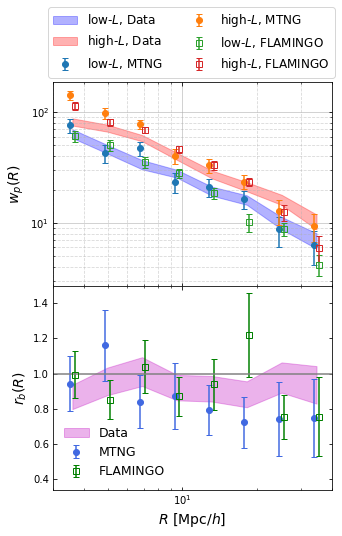

In [24]:

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(5, 7.5),
    sharex=True
)

# ---------- 上面 ----------
ax1.fill_between(rcen,wp1_100-wp_err1_100,wp1_100+wp_err1_100,alpha=0.3,color='b', label='low-$L$, Data')
ax1.fill_between(rcen,wp2_100-wp_err2_100,wp2_100+wp_err2_100,alpha=0.3,color='r', label='high-$L$, Data')
ax1.errorbar(rp_centers*10**-0.01, wp_small,  yerr=wp_err_small,  fmt='o',  capsize=3, label='low-$L$, MTNG')
ax1.errorbar(rp_centers*10**-0.01, wp_large,  yerr=wp_err_large,  fmt='o',  capsize=3, label='high-$L$, MTNG')
ax1.errorbar(rp_centers*10**0.01, wp_small_flamingo,  yerr=wp_err_small_flamingo,  fmt='s', capsize=3, label='low-$L$, FLAMINGO',markerfacecolor='none')
ax1.errorbar(rp_centers*10**0.01, wp_large_flamingo,  yerr=wp_err_large_flamingo,  fmt='s', capsize=3, label='high-$L$, FLAMINGO',markerfacecolor='none')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('$w_p$')
ax1.legend(loc=(-0.015,1.02),fontsize=12., facecolor='none',ncol=2)
ax1.grid(True, which='major', linestyle='-', alpha=0.7)
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)

# ---------- 下面 ----------
ax2.fill_between(rcen,ratio_100-ratio_err_100,ratio_100+ratio_err_100,alpha=0.3,color='m', label='Data')
ax2.errorbar(rp_centers*10**-0.01, ratio_mean,         yerr=ratio_err,   c='royalblue',      fmt='o',  capsize=3, label='MTNG')
ax2.errorbar(rp_centers*10**0.01, ratio_mean_flamingo, yerr=ratio_err_flamingo, fmt='s',c='g', capsize=3,markerfacecolor='none', label='FLAMINGO')
ax2.plot([0, 100], [1, 1], c='gray')
ax2.set_xscale('log')
ax2.set_xlim(3, 40)
ax2.set_ylim(0.34, 1.5)
ax2.set_xlabel('$r_p$ [Mpc/$h$]')
ax2.set_ylabel('ratio')
ax1.set_ylabel('$w_p (R)$',fontsize=14)
ax2.set_ylabel('$r_b (R)$',fontsize=14)
ax2.set_xlabel(r'$R$ [Mpc/$h$]',fontsize=14)
ax2.legend(fontsize=12.5, frameon=False, facecolor='none',loc='lower left')

ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# 关键：去掉中间空隙
fig.subplots_adjust(hspace=0)
plt.savefig('sim_wp-diff_mag.png',bbox_inches = 'tight',dpi=200)

#covr_MTNG=np.loadtxt("wp_pipeline-real_data_measurement/ratio_cov-MTNG.dat")
#covr_Flamingo=np.loadtxt("wp_pipeline-real_data_measurement/ratio_cov-Flamingo.dat")
#covr_obs=np.loadtxt("wp_pipeline-real_data_measurement/ratio_cov_100-obs.dat")

cov=covr_obs+covr_MTNG
inv_ratio_cov=np.linalg.inv(cov)
diff=np.mat(ratio_100-ratio_mean)
snr=np.dot(diff, np.dot(inv_ratio_cov, diff.T))[0,0]
print("MTNG: ",snr)

print(covr_obs.shape,covr_flamingo.shape)
cov=covr_obs+covr_flamingo
inv_ratio_cov=np.linalg.inv(cov)
diff=np.mat(ratio_mean_flamingo-ratio_100)
snr=np.dot(diff, np.dot(inv_ratio_cov, diff.T))[0,0]
print("Flamingo: ",snr)



diff = ratio_mean - ratio_100
C = covr_obs + covr_MTNG
chi2 = diff @ solve(C, diff)
nu = diff.size               # or N_bin - p if you fitted p params to the same data
chi2_red = chi2 / nu
pval = 1.0 - chi2dist.cdf(chi2, df=nu)

print(f"MTNG: chi2 = {chi2:.2f},  chi2_red = {chi2_red:.2f},  dof = {nu},  p = {pval:.3f}")

diff = ratio_mean_flamingo - ratio_100
C = covr_obs + covr_flamingo
chi2 = diff @ solve(C, diff)
nu = diff.size               # or N_bin - p if you fitted p params to the same data
chi2_red = chi2 / nu
pval = 1.0 - chi2dist.cdf(chi2, df=nu)

print(f"Flamingo: chi2 = {chi2:.2f},  chi2_red = {chi2_red:.2f},  dof = {nu},  p = {pval:.3f}")